## Environment Setup

In [1]:
# Package installation and validation
import sys
import subprocess

def install_if_missing(package):
    """Install package if not available in current environment"""
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages for data analysis
required_packages = ['pandas', 'matplotlib', 'seaborn', 'plotly', 'wordcloud', 'ipywidgets']
for package in required_packages:
    install_if_missing(package)

print("Environment setup completed successfully.")

Environment setup completed successfully.


In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from datetime import datetime, timedelta
from collections import Counter
import warnings
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Project-specific modules
from scraper_mariadb import StackOverflowScraperMariaDB
from mariadb_crud import MariaDBCRUD
from unified_scraper import StackOverflowScraper, QuestionData

# Configure visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All dependencies loaded successfully.")

All dependencies loaded successfully.


## Data Collection System

In [3]:
# Initialize data collection system
scraper = None
scraping_results = {}

def initialize_scraper():
    """Initialize MariaDB-backed scraper instance"""
    global scraper
    try:
        scraper = StackOverflowScraperMariaDB()
        print("Scraper initialized with MariaDB connection")
        return True
    except Exception as e:
        print(f"Scraper initialization failed: {e}")
        return False

# System initialization
if initialize_scraper():
    print("Data collection system ready")
else:
    print("Please verify MariaDB connection and configuration")

Database 'so_scrapper' doesn't exist, creating it...
Database 'so_scrapper' created successfully
Connected to MariaDB database: so_scrapper
Database tables created/verified successfully
Scraper initialized with MariaDB connection
Data collection system ready


In [4]:
# Data collection interface
method_dropdown = widgets.Dropdown(
    options=[
        ('Stack Exchange API (Recommended - Most Reliable)', 'api'),
        ('Beautiful Soup (HTML parsing)', 'beautifulsoup'),
        ('Selenium (Browser automation - UNSTABLE)', 'selenium')
    ],
    value='api',  # Default to most reliable method
    description='Collection Method:',
    style={'description_width': 'initial'}
)

# Add method recommendation info with Selenium warning
method_info = widgets.HTML(
    value="""
    <div style='padding: 10px; background-color: #d4edda; border: 1px solid #c3e6cb; border-radius: 5px; margin: 10px 0;'>
        <strong>Recommendation:</strong> Use the <strong>Stack Exchange API</strong> for best results.<br>
        <strong>⚠️ Selenium Issues:</strong> Currently experiencing timeout errors due to page loading issues.
    </div>
    """
)

num_questions_input = widgets.IntText(
    value=20,
    description='Questions to collect:',
    style={'description_width': 'initial'}
)

avoid_duplicates_checkbox = widgets.Checkbox(
    value=True,
    description='Skip duplicate questions',
    style={'description_width': 'initial'}
)

delete_database_checkbox = widgets.Checkbox(
    value=False,
    description='Clear database before collection',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

warning_message = widgets.HTML(
    value="""
    <div style='padding: 10px; background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 5px; margin: 10px 0;'>
        <strong>Warning:</strong> This will permanently delete all existing data.
    </div>
    """,
    layout=widgets.Layout(display='none')
)

# Selenium-specific warning
selenium_warning = widgets.HTML(
    value="""
    <div style='padding: 10px; background-color: #f8d7da; border: 1px solid #f5c6cb; border-radius: 5px; margin: 10px 0;'>
        <strong>⚠️ Selenium Method Selected:</strong><br>
        Selenium is currently experiencing issues with:<br>
        • TimeoutExceptions (elements not loading in time)<br>
        • Stale element reference errors<br>
        • Chrome browser compatibility problems<br><br>
        <strong>Strongly recommended:</strong> Use "Stack Exchange API" instead for reliable results.
    </div>
    """,
    layout=widgets.Layout(display='none')
)

def toggle_warning(change):
    """Toggle warning visibility based on delete option"""
    warning_message.layout.display = 'block' if change['new'] else 'none'

def toggle_selenium_warning(change):
    """Show/hide Selenium warning based on method selection"""
    if change['new'] == 'selenium':
        selenium_warning.layout.display = 'block'
    else:
        selenium_warning.layout.display = 'none'

delete_database_checkbox.observe(toggle_warning, names='value')
method_dropdown.observe(toggle_selenium_warning, names='value')

start_button = widgets.Button(
    description='Start Collection',
    button_style='primary',
    layout=widgets.Layout(width='200px', height='40px')
)

output_area = widgets.Output()

def clear_database_tables(scraper):
    """Clear all database tables in correct order"""
    cursor = scraper.crud.connection.cursor()
    try:
        # Delete in correct order to avoid foreign key constraint issues
        cursor.execute("DELETE FROM question_tags")
        cursor.execute("DELETE FROM questions") 
        cursor.execute("DELETE FROM authors")
        cursor.execute("DELETE FROM tags")
        scraper.crud.connection.commit()
        return True
    except Exception as e:
        scraper.crud.connection.rollback()
        print(f"Error clearing database: {e}")
        return False
    finally:
        cursor.close()

def execute_collection(button):
    """Execute data collection with specified parameters"""
    global scraping_results
    
    with output_area:
        clear_output(wait=True)
        
        print("Initiating data collection...")
        print(f"Method: {method_dropdown.label}")
        print(f"Target: {num_questions_input.value} questions")
        print(f"Duplicate handling: {'Skip' if avoid_duplicates_checkbox.value else 'Allow'}")
        print(f"Database reset: {'Yes' if delete_database_checkbox.value else 'No'}")
        print("-" * 50)
        
        # Strong warning about Selenium method
        if method_dropdown.value == 'selenium':
            print("🚨 CRITICAL WARNING: Selenium Method Selected")
            print("   Selenium is currently experiencing major stability issues:")
            print("   • TimeoutException errors (elements not loading)")
            print("   • Stale element reference errors")
            print("   • Chrome browser compatibility problems")
            print("   • High failure rate")
            print()
            print("   RECOMMENDATION: Switch to 'Stack Exchange API' for reliable results")
            print("   Continuing with Selenium anyway...")
            print("-" * 50)
        
        if not scraper:
            print("Error: Scraper not initialized")
            return
        
        try:
            # Handle database reset if requested
            if delete_database_checkbox.value:
                print("Clearing existing database...")
                try:
                    current_stats = scraper.get_database_stats()
                    print(f"Removing {current_stats['total_questions']:,} questions, {current_stats['total_authors']:,} authors, {current_stats['total_tags']:,} tags")
                except:
                    pass
                
                # Clear database tables using the new function
                if clear_database_tables(scraper):
                    print("Database cleared successfully\n")
                else:
                    print("Warning: Database clearing had issues, continuing anyway\n")
            
            # Execute collection with enhanced error handling
            print("Starting data collection...")
            result = scraper.scrape_and_store(
                method=method_dropdown.value,
                num_questions=num_questions_input.value,
                avoid_duplicates=avoid_duplicates_checkbox.value
            )
            
            scraping_results[method_dropdown.value] = result
            
            # Display results
            print("\nCOLLECTION COMPLETED")
            print("=" * 30)
            print(f"Method: {result['method']}")
            print(f"Retrieved: {result['scraped_count']} questions")
            print(f"Stored: {result['stored_count']} new entries")
            print(f"Duplicates: {result['duplicates_skipped']} skipped")
            print(f"Execution time: {result['total_time']:.2f}s")
            
            if result['stored_question_ids']:
                print(f"Sample IDs: {result['stored_question_ids'][:5]}")
            
            # Success message with method-specific advice
            if method_dropdown.value == 'selenium' and result['stored_count'] > 0:
                print("\n🎉 UNEXPECTED SUCCESS: Selenium worked despite known issues!")
                print("   Consider yourself lucky - this method is very unreliable")
            elif method_dropdown.value == 'api':
                print(f"\n✅ API collection completed successfully - reliable as expected")
            
        except Exception as e:
            print(f"\n❌ Collection failed: {e}")
            
            # Enhanced method-specific error advice
            if method_dropdown.value == 'selenium':
                print("\n🚨 SELENIUM FAILURE (Expected)")
                print("   This is a known issue with the Selenium scraper.")
                print("   The error indicates:")
                
                error_str = str(e).lower()
                if 'timeout' in error_str:
                    print("   • TimeoutException: Browser couldn't find expected elements")
                    print("   • This usually means the page structure changed or loading is slow")
                elif 'stale' in error_str:
                    print("   • Stale Element: Page elements became invalid during scraping")
                    print("   • This happens when the page DOM updates dynamically")
                else:
                    print("   • General Selenium/Chrome browser error")
                
                print("\n   💡 SOLUTIONS:")
                print("   1. ✅ Use 'Stack Exchange API' (RECOMMENDED)")
                print("   2. Try 'Beautiful Soup' as alternative")
                print("   3. Reduce number of questions if using Selenium")
                print("   4. Check Chrome browser version compatibility")
                
            elif method_dropdown.value == 'beautifulsoup':
                print("\n💡 Beautiful Soup Troubleshooting:")
                print("   • Try using 'Stack Exchange API' for more reliable results")
                print("   • HTML structure may have changed")
                print("   • Network connectivity issues")
            else:
                print("\n💡 API Troubleshooting:")
                print("   • Check internet connection")
                print("   • API rate limits may apply")
                print("   • Stack Exchange API may be temporarily unavailable")
            
            print(f"\nDetailed error information:")
            import traceback
            traceback.print_exc()

start_button.on_click(execute_collection)

# Display interface with enhanced warnings
display(widgets.VBox([
    widgets.HTML("<h3>Collection Parameters</h3>"),
    method_info,
    method_dropdown,
    selenium_warning,
    num_questions_input,
    avoid_duplicates_checkbox,
    delete_database_checkbox,
    warning_message,
    start_button,
    output_area
]))

## Database Statistics

In [5]:
# Generate database overview
def get_database_overview():
    """Retrieve comprehensive database statistics"""
    if not scraper:
        print("Scraper not initialized")
        return None
    
    try:
        stats = scraper.get_database_stats()
        
        print("DATABASE OVERVIEW")
        print("=" * 50)
        print(f"Total Questions: {stats['total_questions']:,}")
        print(f"Total Authors: {stats['total_authors']:,}")
        print(f"Total Tags: {stats['total_tags']:,}")
        print(f"Last Updated: {stats['last_scraped']}")
        
        if stats['questions_by_method']:
            print("\nCollection Methods:")
            for method, count in stats['questions_by_method'].items():
                print(f"  • {method}: {count:,} questions")
        
        return stats
    
    except Exception as e:
        print(f"Error retrieving database statistics: {e}")
        return None

# Display current database state
db_stats = get_database_overview()

DATABASE OVERVIEW
Total Questions: 2,000
Total Authors: 1,836
Total Tags: 2,586
Last Updated: 2025-08-08 14:04:56

Collection Methods:
  • api: 2,000 questions


## Data Loading and Preprocessing

In [6]:
# Load and preprocess data for analysis
def load_data_from_database(limit=1000):
    """Load questions from database into pandas DataFrame with preprocessing"""
    if not scraper:
        print("Scraper not initialized")
        return None
    
    try:
        # Retrieve questions from database
        questions = scraper.crud.get_questions(limit=limit)
        
        if not questions:
            print("No questions found in database")
            return None
        
        # Create DataFrame
        df = pd.DataFrame(questions)
        
        # Data preprocessing
        if 'publication_date' in df.columns:
            df['publication_date'] = pd.to_datetime(df['publication_date'])
        
        if 'scraped_at' in df.columns:
            df['scraped_at'] = pd.to_datetime(df['scraped_at'])
        
        # Feature engineering
        if 'text' in df.columns:
            df['text_length'] = df['text'].str.len().fillna(0)
        
        if 'title' in df.columns:
            df['title_length'] = df['title'].str.len().fillna(0)
        
        # Tag processing
        if 'tags' in df.columns:
            df['num_tags'] = df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
        
        print(f"Loaded {len(df)} questions from database")
        print(f"Date range: {df['publication_date'].min()} to {df['publication_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load dataset
df = load_data_from_database(limit=1000)

if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display sample
    display(df[['title', 'author_name', 'num_tags', 'publication_date', 'scrape_method']].head())

Loaded 1000 questions from database
Date range: 2025-08-01 18:26:53 to 2025-08-05 17:57:29

Dataset shape: (1000, 14)
Columns: ['id', 'title', 'link', 'text', 'author_id', 'publication_date', 'scraped_at', 'scrape_method', 'author_name', 'author_reputation', 'tags', 'text_length', 'title_length', 'num_tags']


,title,author_name,num_tags,publication_date,scrape_method
0,Hibernate validator ClassNotFoundException in ...,djmj,2,2025-08-01 18:26:53,api
1,How does Django support asynchronous operations,Dylan,2,2025-08-01 18:27:41,api
2,Database Design for attendance managment app,Yusuf Bouzekri,3,2025-08-01 18:28:22,api
3,Harmless SQL clutter on startup with no tables,cp.,1,2025-08-01 18:31:37,api
4,Polars bug using windowed aggregate functions ...,jpm_phd,4,2025-08-01 18:34:31,api


## Simple Tag Analysis

This section helps you understand what programming topics are most popular in your Stack Overflow data. We'll look at:
- Which tags appear most often
- How many tags each question has
- Simple charts to visualize the data

In [7]:
# Simple function to analyze tags
def simple_tag_analysis(df):
    """
    Analyze tags in a simple, easy-to-understand way
    Perfect for beginners in data analysis!
    """
    if df is None or df.empty:
        print("No data available for analysis")
        return None
    
    print("TAG ANALYSIS RESULTS")
    print("=" * 40)
    
    # Step 1: Count all tags
    # We need to "flatten" the tag lists - combine all tags from all questions into one big list
    all_tags = []
    for question_tags in df['tags']:
        if isinstance(question_tags, list):  # Make sure it's actually a list
            all_tags.extend(question_tags)  # Add all tags from this question to our big list
    
    # Step 2: Count how many times each tag appears
    from collections import Counter
    tag_counts = Counter(all_tags)
    
    # Step 3: Basic statistics
    total_questions = len(df)
    total_tag_uses = len(all_tags)
    unique_tags = len(tag_counts)
    avg_tags_per_question = df['num_tags'].mean()
    
    print(f"Basic Numbers:")
    print(f"   • Total questions: {total_questions:,}")
    print(f"   • Total tag uses: {total_tag_uses:,}")
    print(f"   • Unique tags: {unique_tags:,}")
    print(f"   • Average tags per question: {avg_tags_per_question:.1f}")
    
    # Step 4: Show top 10 most popular tags
    top_10_tags = tag_counts.most_common(10)
    print(f"\nTOP 10 MOST POPULAR TAGS:")
    for i, (tag, count) in enumerate(top_10_tags, 1):
        percentage = (count / total_tag_uses) * 100
        print(f"   {i:2d}. {tag:<15} {count:3d} uses ({percentage:.1f}%)")
    
    return tag_counts, top_10_tags

# Run the analysis
if df is not None:
    tag_results = simple_tag_analysis(df)
else:
    print("Please load data first!")

TAG ANALYSIS RESULTS
Basic Numbers:
   • Total questions: 1,000
   • Total tag uses: 3,122
   • Unique tags: 1,540
   • Average tags per question: 3.1

TOP 10 MOST POPULAR TAGS:
    1. python          116 uses (3.7%)
    2. javascript       55 uses (1.8%)
    3. c#               49 uses (1.6%)
    4. c++              49 uses (1.6%)
    5. java             44 uses (1.4%)
    6. android          44 uses (1.4%)
    7. typescript       31 uses (1.0%)
    8. html             30 uses (1.0%)
    9. reactjs          30 uses (1.0%)
   10. ios              28 uses (0.9%)


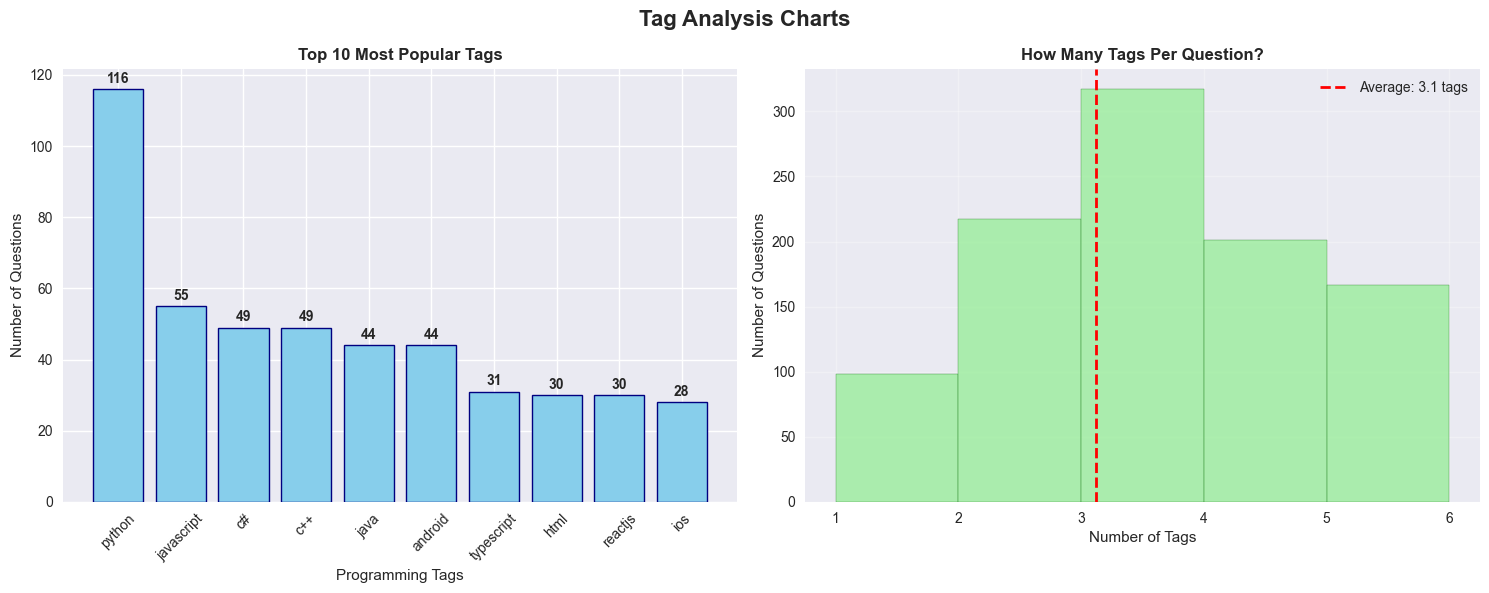


Key Insights:
   • Most questions have 3 tags
   • On average, questions have 3.1 tags
   • 'python' is by far the most popular topic!


In [8]:
# Create simple charts for tag analysis
def create_simple_tag_charts(tag_results, df):
    """
    Create easy-to-understand charts using matplotlib
    Much simpler than the complex plotly version!
    """
    if not tag_results or df is None:
        print("No data to visualize")
        return
    
    tag_counts, top_10_tags = tag_results
    
    # Set up the figure with 2 charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Tag Analysis Charts', fontsize=16, fontweight='bold')
    
    # Chart 1: Bar chart of top 10 tags
    tags = [tag for tag, count in top_10_tags]
    counts = [count for tag, count in top_10_tags]
    
    bars = ax1.bar(tags, counts, color='skyblue', edgecolor='navy', linewidth=1)
    ax1.set_title('Top 10 Most Popular Tags', fontweight='bold')
    ax1.set_xlabel('Programming Tags')
    ax1.set_ylabel('Number of Questions')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Histogram of tags per question
    ax2.hist(df['num_tags'], bins=range(1, df['num_tags'].max() + 2), 
             color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    ax2.set_title('How Many Tags Per Question?', fontweight='bold')
    ax2.set_xlabel('Number of Tags')
    ax2.set_ylabel('Number of Questions')
    ax2.grid(True, alpha=0.3)
    
    # Add some statistics text
    avg_tags = df['num_tags'].mean()
    most_common_tag_count = df['num_tags'].mode().iloc[0]
    ax2.axvline(avg_tags, color='red', linestyle='--', linewidth=2, 
               label=f'Average: {avg_tags:.1f} tags')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some insights
    print("\nKey Insights:")
    print(f"   • Most questions have {most_common_tag_count} tags")
    print(f"   • On average, questions have {avg_tags:.1f} tags")
    print(f"   • '{top_10_tags[0][0]}' is by far the most popular topic!")

# Create the charts
if df is not None and 'tag_results' in locals():
    create_simple_tag_charts(tag_results, df)

## Simple Time Analysis

Let's look at **when** questions were posted! This helps us understand:
- Which days of the week are most active
- What time of day people ask questions
- Basic patterns over time

*Note: Time analysis works best when you have questions from different days/weeks*

In [9]:
# Simple time pattern analysis
def simple_time_analysis(df):
    """
    Analyze when questions are posted - simplified for beginners
    """
    if df is None or df.empty or 'publication_date' not in df.columns:
        print("No time data available")
        return None
    
    # Remove questions without dates
    df_with_dates = df.dropna(subset=['publication_date'])
    
    if df_with_dates.empty:
        print("No valid dates found in the data")
        return None
    
    print("TIME ANALYSIS RESULTS")
    print("=" * 40)
    
    # Basic time info
    earliest_question = df_with_dates['publication_date'].min()
    latest_question = df_with_dates['publication_date'].max()
    total_days = (latest_question - earliest_question).days + 1
    
    print(f"Basic Time Info:")
    print(f"   • First question: {earliest_question.strftime('%Y-%m-%d %H:%M')}")
    print(f"   • Last question: {latest_question.strftime('%Y-%m-%d %H:%M')}")
    print(f"   • Time span: {total_days} days")
    print(f"   • Questions per day: {len(df_with_dates) / max(1, total_days):.1f}")
    
    # Add simple time columns (easier to understand than complex datetime operations)
    df_time = df_with_dates.copy()
    df_time['day_name'] = df_time['publication_date'].dt.day_name()  # Monday, Tuesday, etc.
    df_time['hour'] = df_time['publication_date'].dt.hour           # 0-23 hour of day
    df_time['date'] = df_time['publication_date'].dt.date          # Just the date part
    
    # Count questions by day of week
    print(f"\nQuestions by Day of Week:")
    day_counts = df_time['day_name'].value_counts()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for day in day_order:
        if day in day_counts:
            count = day_counts[day]
            print(f"   • {day:<10}: {count:3d} questions")
        else:
            print(f"   • {day:<10}:   0 questions")
    
    # Find busiest day
    if not day_counts.empty:
        busiest_day = day_counts.index[0]
        busiest_count = day_counts.iloc[0]
        print(f"\nBusiest day: {busiest_day} ({busiest_count} questions)")
    
    return df_time, day_counts

# Run the analysis
if df is not None:
    time_results = simple_time_analysis(df)
    if time_results:
        df_time, day_counts = time_results
else:
    print("Please load data first!")

TIME ANALYSIS RESULTS
Basic Time Info:
   • First question: 2025-08-01 18:26
   • Last question: 2025-08-05 17:57
   • Time span: 4 days
   • Questions per day: 250.0

Questions by Day of Week:
   • Monday    : 314 questions
   • Tuesday   : 257 questions
   • Wednesday :   0 questions
   • Thursday  :   0 questions
   • Friday    :  74 questions
   • Saturday  : 168 questions
   • Sunday    : 187 questions

Busiest day: Monday (314 questions)


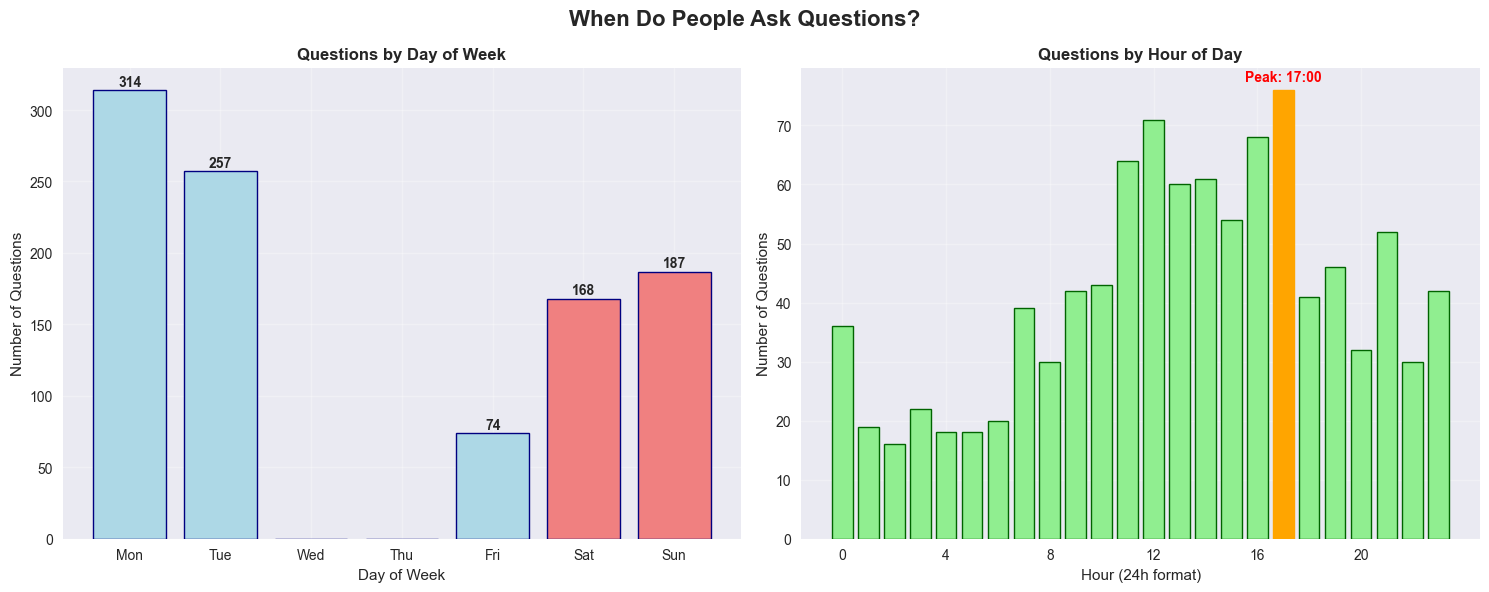


Time Insights:
   • Most active day: Monday
   • Weekdays vs Weekends: 64.5% vs 35.5%
   • Most active hour: 17:00 (76 questions)


In [11]:
# Create simple time charts
def create_simple_time_charts(df_time, day_counts):
    """
    Create simple, easy-to-read time charts
    """
    if df_time is None or day_counts is None:
        print("No time data to visualize")
        return
    
    # Create a figure with 2 charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('When Do People Ask Questions?', fontsize=16, fontweight='bold')
    
    # Chart 1: Questions by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    # Reorder the data to match our preferred order
    ordered_counts = []
    ordered_days = []
    
    for day in day_order:
        if day in day_counts:
            ordered_days.append(day[:3])  # Shorten to Mon, Tue, etc.
            ordered_counts.append(day_counts[day])
        else:
            ordered_days.append(day[:3])
            ordered_counts.append(0)
    
    # Create colorful bars - weekdays vs weekends
    colors = ['lightblue' if day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'] else 'lightcoral' 
              for day in ordered_days]
    
    bars1 = ax1.bar(ordered_days, ordered_counts, color=colors, edgecolor='navy', linewidth=1)
    ax1.set_title('Questions by Day of Week', fontweight='bold')
    ax1.set_xlabel('Day of Week')
    ax1.set_ylabel('Number of Questions')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars1, ordered_counts):
        if count > 0:  # Only show label if there are questions
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Questions by hour of day
    hour_counts = df_time['hour'].value_counts().sort_index()
    
    # Fill in missing hours with 0
    all_hours = range(24)
    hour_data = [hour_counts.get(hour, 0) for hour in all_hours]
    
    bars2 = ax2.bar(all_hours, hour_data, color='lightgreen', edgecolor='darkgreen', linewidth=1)
    ax2.set_title('Questions by Hour of Day', fontweight='bold')
    ax2.set_xlabel('Hour (24h format)')
    ax2.set_ylabel('Number of Questions')
    ax2.set_xticks(range(0, 24, 4))  # Show every 4 hours
    ax2.grid(True, alpha=0.3)
    
    # Highlight peak hour
    if hour_data:
        peak_hour = hour_data.index(max(hour_data))
        bars2[peak_hour].set_color('orange')
        ax2.text(peak_hour, max(hour_data) + 1, f'Peak: {peak_hour}:00', 
                ha='center', va='bottom', fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\nTime Insights:")
    if ordered_counts:
        busiest_day_idx = ordered_counts.index(max(ordered_counts))
        busiest_day = day_order[busiest_day_idx]
        print(f"   • Most active day: {busiest_day}")
        
        weekday_total = sum(ordered_counts[:5])  # Mon-Fri
        weekend_total = sum(ordered_counts[5:])   # Sat-Sun
        if weekday_total + weekend_total > 0:
            weekday_pct = (weekday_total / (weekday_total + weekend_total)) * 100
            print(f"   • Weekdays vs Weekends: {weekday_pct:.1f}% vs {100-weekday_pct:.1f}%")
    
    if hour_data:
        peak_hour = hour_data.index(max(hour_data))
        print(f"   • Most active hour: {peak_hour}:00 ({max(hour_data)} questions)")

# Create the charts
if 'time_results' in locals() and time_results:
    df_time, day_counts = time_results
    create_simple_time_charts(df_time, day_counts)

## Simple Author Analysis

In [12]:
# Simple author analysis
def simple_author_analysis(df):
    """
    Analyze authors in a simple, beginner-friendly way
    """
    if df is None or df.empty:
        print("No data available for author analysis")
        return None
    
    print("AUTHOR ANALYSIS RESULTS")
    print("=" * 40)
    
    # Basic author statistics
    total_questions = len(df)
    unique_authors = df['author_name'].nunique()
    
    print(f"Basic Numbers:")
    print(f"   • Total questions: {total_questions:,}")
    print(f"   • Unique authors: {unique_authors:,}")
    print(f"   • Questions per author: {total_questions / unique_authors:.1f}")
    
    # Count how many questions each author has
    author_question_counts = df['author_name'].value_counts()
    
    # Most active authors (top 10)
    print(f"\nTOP 10 MOST ACTIVE AUTHORS:")
    for i, (author, question_count) in enumerate(author_question_counts.head(10).items(), 1):
        # Get this author's reputation (if available)
        author_rep = df[df['author_name'] == author]['author_reputation'].iloc[0]
        rep_str = f"{author_rep:,}" if pd.notna(author_rep) else "Unknown"
        print(f"   {i:2d}. {author:<25} {question_count:2d} questions (Rep: {rep_str})")
    
    # Author activity distribution
    print(f"\nAuthor Activity Patterns:")
    one_question = (author_question_counts == 1).sum()
    few_questions = ((author_question_counts >= 2) & (author_question_counts <= 3)).sum()
    many_questions = (author_question_counts > 3).sum()
    
    print(f"   • Authors with 1 question: {one_question} ({one_question/unique_authors*100:.1f}%)")
    print(f"   • Authors with 2-3 questions: {few_questions} ({few_questions/unique_authors*100:.1f}%)")
    print(f"   • Authors with 4+ questions: {many_questions} ({many_questions/unique_authors*100:.1f}%)")
    
    # Reputation analysis (if available)
    if 'author_reputation' in df.columns:
        rep_data = df['author_reputation'].dropna()
        if not rep_data.empty:
            print(f"\nReputation Analysis:")
            print(f"   • Average reputation: {rep_data.mean():,.0f} points")
            print(f"   • Median reputation: {rep_data.median():,.0f} points")
            print(f"   • Highest reputation: {rep_data.max():,.0f} points")
            print(f"   • Lowest reputation: {rep_data.min():,.0f} points")
            
            # Reputation categories
            low_rep = (rep_data < 100).sum()
            medium_rep = ((rep_data >= 100) & (rep_data < 1000)).sum()
            high_rep = (rep_data >= 1000).sum()
            
            total_with_rep = len(rep_data)
            print(f"\nReputation Categories:")
            print(f"   • Low (< 100): {low_rep} authors ({low_rep/total_with_rep*100:.1f}%)")
            print(f"   • Medium (100-999): {medium_rep} authors ({medium_rep/total_with_rep*100:.1f}%)")
            print(f"   • High (1000+): {high_rep} authors ({high_rep/total_with_rep*100:.1f}%)")
    
    return author_question_counts

# Run the analysis
if df is not None:
    author_results = simple_author_analysis(df)
else:
    print("Please load data first!")

AUTHOR ANALYSIS RESULTS
Basic Numbers:
   • Total questions: 1,000
   • Unique authors: 951
   • Questions per author: 1.1

TOP 10 MOST ACTIVE AUTHORS:
    1. einpoklum                  4 questions (Rep: 135,725.0)
    2. Enrico                     4 questions (Rep: 6,592.0)
    3. Alex                       3 questions (Rep: 1.0)
    4. Daniel                     3 questions (Rep: 15,619.0)
    5. Mikko Ohtamaa              3 questions (Rep: 84,446.0)
    6. Joe J                      3 questions (Rep: 1,075.0)
    7. mcu                        3 questions (Rep: 3,590.0)
    8. CalebK                     3 questions (Rep: 663.0)
    9. developer8492              2 questions (Rep: 97.0)
   10. David Callanan             2 questions (Rep: 5,858.0)

Author Activity Patterns:
   • Authors with 1 question: 912 (95.9%)
   • Authors with 2-3 questions: 37 (3.9%)
   • Authors with 4+ questions: 2 (0.2%)

Reputation Analysis:
   • Average reputation: 2,943 points
   • Median reputation: 88 poi

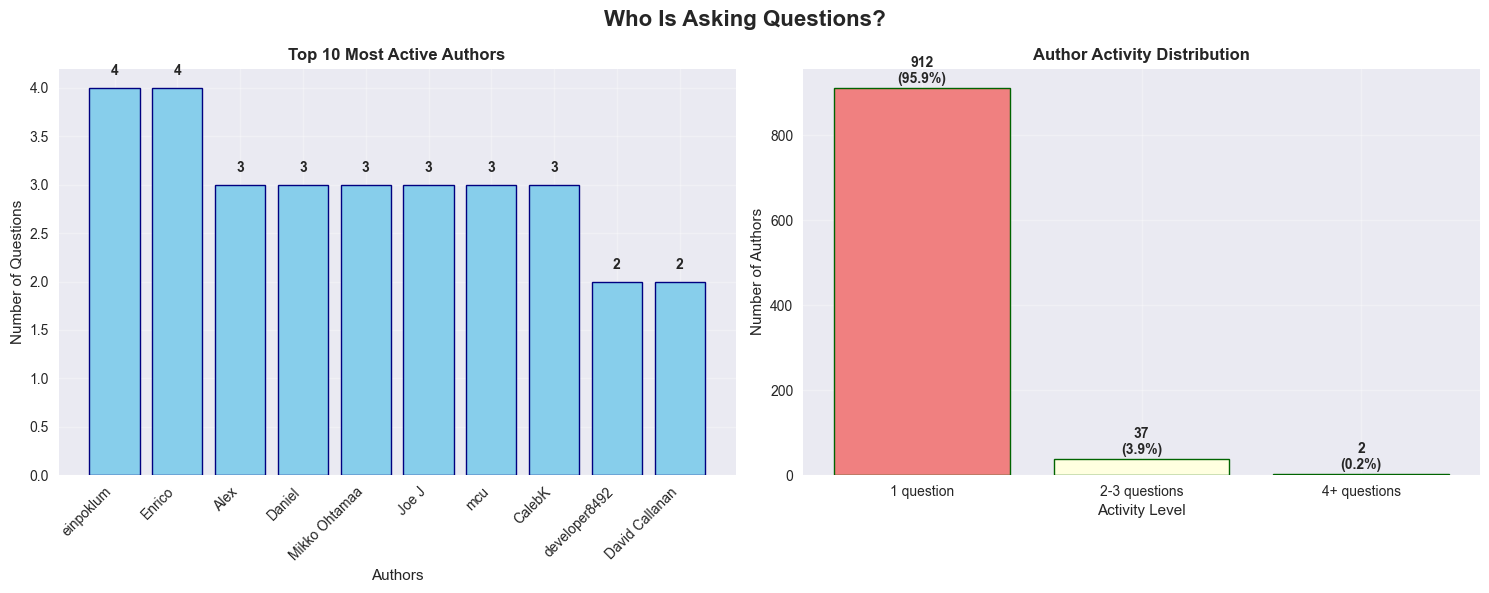


Author Insights:
   • Most active author: 'einpoklum' with 4 questions
   • 95.9% of authors ask only 1 question
   • 2 authors are very active (4+ questions)


In [13]:
# Create simple author charts
def create_simple_author_charts(df, author_question_counts):
    """
    Create simple charts about authors
    """
    if df is None or author_question_counts is None:
        print("No author data to visualize")
        return
    
    # Create a figure with 2 charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Who Is Asking Questions?', fontsize=16, fontweight='bold')
    
    # Chart 1: Top 10 most active authors
    top_10_authors = author_question_counts.head(10)
    author_names = [name[:20] + '...' if len(name) > 20 else name for name in top_10_authors.index]
    question_counts = top_10_authors.values
    
    bars1 = ax1.bar(range(len(author_names)), question_counts, 
                    color='skyblue', edgecolor='navy', linewidth=1)
    ax1.set_title('Top 10 Most Active Authors', fontweight='bold')
    ax1.set_xlabel('Authors')
    ax1.set_ylabel('Number of Questions')
    ax1.set_xticks(range(len(author_names)))
    ax1.set_xticklabels(author_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars1, question_counts)):
        height = bar.get_height()
        ax1.text(i, height + 0.1, f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Author activity distribution
    activity_labels = ['1 question', '2-3 questions', '4+ questions']
    activity_counts = [
        (author_question_counts == 1).sum(),
        ((author_question_counts >= 2) & (author_question_counts <= 3)).sum(),
        (author_question_counts > 3).sum()
    ]
    
    colors = ['lightcoral', 'lightyellow', 'lightgreen']
    bars2 = ax2.bar(activity_labels, activity_counts, color=colors, 
                    edgecolor='darkgreen', linewidth=1)
    ax2.set_title('Author Activity Distribution', fontweight='bold')
    ax2.set_xlabel('Activity Level')
    ax2.set_ylabel('Number of Authors')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels and percentages on bars
    total_authors = sum(activity_counts)
    for bar, count in zip(bars2, activity_counts):
        height = bar.get_height()
        percentage = (count / total_authors) * 100 if total_authors > 0 else 0
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\nAuthor Insights:")
    if len(author_question_counts) > 0:
        most_active = author_question_counts.index[0]
        most_active_count = author_question_counts.iloc[0]
        print(f"   • Most active author: '{most_active}' with {most_active_count} questions")
        
        single_question_pct = (activity_counts[0] / total_authors) * 100
        print(f"   • {single_question_pct:.1f}% of authors ask only 1 question")
        
        if activity_counts[2] > 0:
            print(f"   • {activity_counts[2]} authors are very active (4+ questions)")

# Create the charts
if df is not None and 'author_results' in locals():
    create_simple_author_charts(df, author_results)

## Simple Content Analysis

Let's examine the **content** of the questions! We'll look at:
- How long questions are (title and text)
- Common words in question titles  
- Simple patterns in the text

*This helps understand what kinds of questions people ask*

In [14]:
# Simple content analysis
def simple_content_analysis(df):
    """
    Analyze question content in a beginner-friendly way
    """
    if df is None or df.empty:
        print("No data available for content analysis")
        return None
    
    print("CONTENT ANALYSIS RESULTS")
    print("=" * 40)
    
    # Basic content statistics
    print(f"Basic Content Stats:")
    
    # Title length analysis
    if 'title_length' in df.columns:
        avg_title_length = df['title_length'].mean()
        min_title_length = df['title_length'].min()
        max_title_length = df['title_length'].max()
        
        print(f"   Title Length:")
        print(f"      • Average: {avg_title_length:.0f} characters")
        print(f"      • Shortest: {min_title_length:.0f} characters")
        print(f"      • Longest: {max_title_length:.0f} characters")
    
    # Question text length analysis
    if 'text_length' in df.columns:
        avg_text_length = df['text_length'].mean()
        min_text_length = df['text_length'].min()
        max_text_length = df['text_length'].max()
        
        print(f"   Question Text Length:")
        print(f"      • Average: {avg_text_length:.0f} characters")
        print(f"      • Shortest: {min_text_length:.0f} characters")
        print(f"      • Longest: {max_text_length:.0f} characters")
    
    # Number of tags analysis
    if 'num_tags' in df.columns:
        avg_tags = df['num_tags'].mean()
        min_tags = df['num_tags'].min()
        max_tags = df['num_tags'].max()
        
        print(f"   Tags per Question:")
        print(f"      • Average: {avg_tags:.1f} tags")
        print(f"      • Minimum: {min_tags:.0f} tags")
        print(f"      • Maximum: {max_tags:.0f} tags")
    
    # Find common words in titles (simplified approach)
    if 'title' in df.columns:
        print(f"\nMost Common Words in Titles:")
        
        # Combine all titles into one big text
        all_titles = ' '.join(df['title'].dropna().astype(str).str.lower())
        
        # Split into words and clean them up
        words = all_titles.split()
        
        # Remove very common words (stop words) and short words
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
            'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'how', 'what', 'when',
            'where', 'why', 'who', 'which', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she',
            'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'its', 'our', 'their'
        }
        
        # Keep only meaningful words
        meaningful_words = []
        for word in words:
            # Remove punctuation and keep only letters
            clean_word = ''.join(char for char in word if char.isalpha())
            # Keep words that are long enough and not stop words
            if len(clean_word) >= 3 and clean_word not in stop_words:
                meaningful_words.append(clean_word)
        
        # Count word frequency
        from collections import Counter
        word_counts = Counter(meaningful_words)
        
        # Show top 10 words
        top_10_words = word_counts.most_common(10)
        for i, (word, count) in enumerate(top_10_words, 1):
            print(f"      {i:2d}. {word:<15} appears {count:3d} times")
    
    # Simple content categories based on length
    if 'text_length' in df.columns:
        print(f"\nQuestion Length Categories:")
        short_questions = (df['text_length'] < 500).sum()
        medium_questions = ((df['text_length'] >= 500) & (df['text_length'] < 2000)).sum()
        long_questions = (df['text_length'] >= 2000).sum()
        
        total = len(df)
        print(f"   • Short questions (< 500 chars): {short_questions} ({short_questions/total*100:.1f}%)")
        print(f"   • Medium questions (500-2000): {medium_questions} ({medium_questions/total*100:.1f}%)")
        print(f"   • Long questions (2000+ chars): {long_questions} ({long_questions/total*100:.1f}%)")
    
    return {
        'word_counts': top_10_words if 'top_10_words' in locals() else None,
        'length_stats': {
            'title_avg': avg_title_length if 'avg_title_length' in locals() else None,
            'text_avg': avg_text_length if 'avg_text_length' in locals() else None
        }
    }

# Run the analysis
if df is not None:
    content_results = simple_content_analysis(df)
else:
    print("Please load data first!")

CONTENT ANALYSIS RESULTS
Basic Content Stats:
   Title Length:
      • Average: 68 characters
      • Shortest: 16 characters
      • Longest: 170 characters
   Question Text Length:
      • Average: 1957 characters
      • Shortest: 106 characters
      • Longest: 26473 characters
   Tags per Question:
      • Average: 3.1 tags
      • Minimum: 1 tags
      • Maximum: 5 tags

Most Common Words in Titles:
       1. not             appears 138 times
       2. using           appears  87 times
       3. from            appears  84 times
       4. error           appears  63 times
       5. file            appears  51 times
       6. data            appears  41 times
       7. use             appears  37 times
       8. custom          appears  35 times
       9. python          appears  33 times
      10. api             appears  32 times

Question Length Categories:
   • Short questions (< 500 chars): 141 (14.1%)
   • Medium questions (500-2000): 562 (56.2%)
   • Long questions (2000+ c

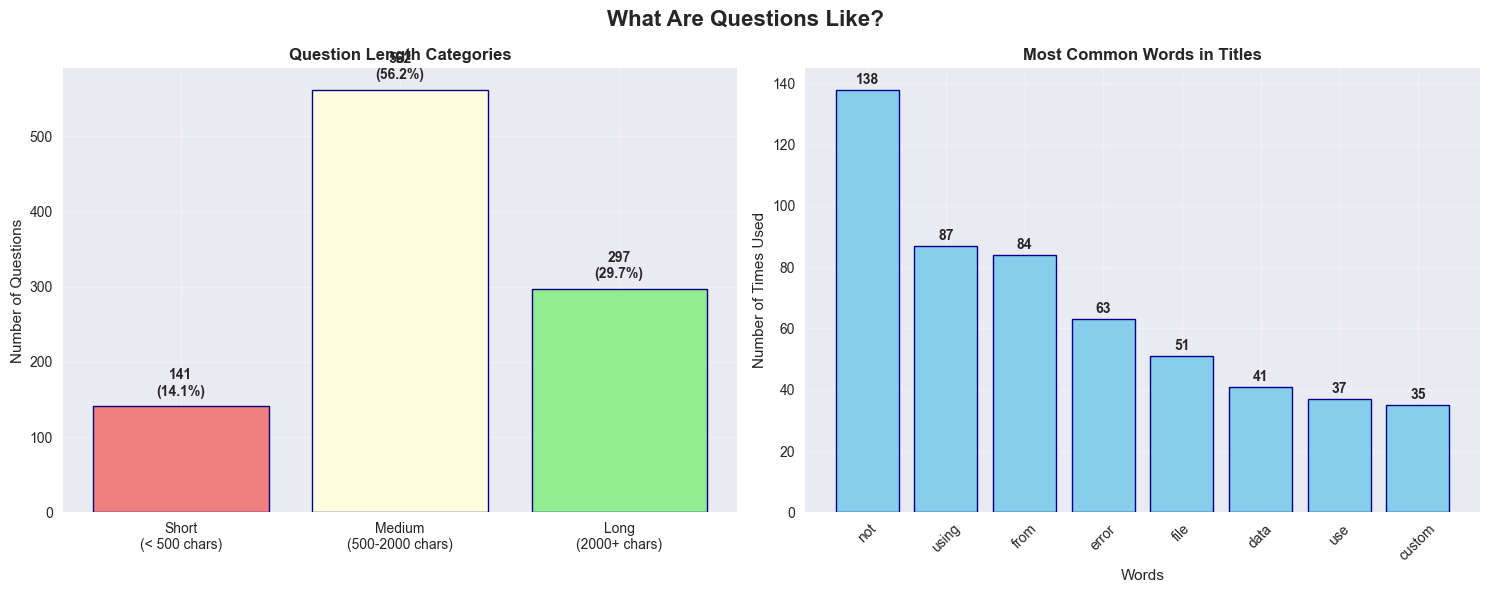


Content Insights:
   • Questions are typically medium-length (1957 characters on average)
   • Most common word in titles: 'not' (appears 138 times)
   • Programming languages mentioned: python


In [15]:
# Create simple content charts
def create_simple_content_charts(df, content_results):
    """
    Create easy-to-understand charts about question content
    """
    if df is None or content_results is None:
        print("No content data to visualize")
        return
    
    # Create a figure with 2 charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('What Are Questions Like?', fontsize=16, fontweight='bold')
    
    # Chart 1: Question length distribution (simple histogram)
    if 'text_length' in df.columns:
        # Create simple categories for easier understanding
        length_categories = []
        category_names = []
        
        short_q = (df['text_length'] < 500).sum()
        medium_q = ((df['text_length'] >= 500) & (df['text_length'] < 2000)).sum()
        long_q = (df['text_length'] >= 2000).sum()
        
        categories = ['Short\n(< 500 chars)', 'Medium\n(500-2000 chars)', 'Long\n(2000+ chars)']
        counts = [short_q, medium_q, long_q]
        colors = ['lightcoral', 'lightyellow', 'lightgreen']
        
        bars1 = ax1.bar(categories, counts, color=colors, edgecolor='navy', linewidth=1)
        ax1.set_title('Question Length Categories', fontweight='bold')
        ax1.set_ylabel('Number of Questions')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars1, counts):
            height = bar.get_height()
            percentage = (count / len(df)) * 100 if len(df) > 0 else 0
            ax1.text(bar.get_x() + bar.get_width()/2., height + len(df)*0.01,
                    f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Most common words in titles
    if content_results['word_counts']:
        top_words = content_results['word_counts'][:8]  # Show top 8 for better visibility
        words = [word for word, count in top_words]
        word_counts = [count for word, count in top_words]
        
        bars2 = ax2.bar(words, word_counts, color='skyblue', edgecolor='darkblue', linewidth=1)
        ax2.set_title('Most Common Words in Titles', fontweight='bold')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Number of Times Used')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars2, word_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print simple insights
    print("\nContent Insights:")
    
    if 'text_length' in df.columns:
        avg_length = df['text_length'].mean()
        if avg_length < 800:
            length_desc = "short"
        elif avg_length < 2000:
            length_desc = "medium-length"
        else:
            length_desc = "long"
        print(f"   • Questions are typically {length_desc} ({avg_length:.0f} characters on average)")
    
    if content_results['word_counts']:
        most_common_word = content_results['word_counts'][0][0]
        most_common_count = content_results['word_counts'][0][1]
        print(f"   • Most common word in titles: '{most_common_word}' (appears {most_common_count} times)")
        
        # Check if it's a programming language
        prog_languages = ['python', 'javascript', 'java', 'php', 'css', 'html', 'sql', 'react', 'angular']
        prog_words = [word for word, count in content_results['word_counts'] if word in prog_languages]
        if prog_words:
            print(f"   • Programming languages mentioned: {', '.join(prog_words[:3])}")

# Create the charts
if df is not None and 'content_results' in locals():
    create_simple_content_charts(df, content_results)

## Simple Summary Report

**What you've learned so far:**
This section creates a simple summary of all your analysis - perfect for sharing with others or keeping as notes!

The summary includes:
- Basic numbers about your dataset
- Most popular topics (tags)
- Most active authors
- Key patterns and trends

*Great for presenting your findings to others!*

In [16]:
# Create a simple, easy-to-read summary
def create_beginner_summary():
    """
    Create a simple summary report that's perfect for junior data analysts
    """
    if df is None:
        print("No data available - please load data first!")
        return
    
    print("SIMPLE ANALYSIS SUMMARY")
    print("=" * 50)
    print("Here's what we discovered about Stack Overflow questions:\n")
    
    # Dataset basics
    print("DATASET OVERVIEW:")
    print(f"   • We analyzed {len(df):,} questions")
    print(f"   • From {df['author_name'].nunique():,} different authors")
    print(f"   • Asked between {df['publication_date'].min().strftime('%Y-%m-%d')} and {df['publication_date'].max().strftime('%Y-%m-%d')}")
    print(f"   • Data collected using: {', '.join(df['scrape_method'].dropna().unique())}")
    
    # Top insights
    print(f"\nKEY FINDINGS:")
    
    # Most popular tag
    if 'tag_results' in globals() and tag_results:
        tag_counts, top_tags = tag_results
        most_popular_tag = top_tags[0][0]
        most_popular_count = top_tags[0][1]
        print(f"   • Most popular programming topic: '{most_popular_tag}' ({most_popular_count} questions)")
    
    # Most active author
    if 'author_results' in globals() and author_results is not None:
        top_author = author_results.index[0]
        author_question_count = author_results.iloc[0]
        print(f"   • Most active author: '{top_author}' ({author_question_count} questions)")
    
    # Average question length
    if 'text_length' in df.columns:
        avg_length = df['text_length'].mean()
        if avg_length < 800:
            length_category = "short and concise"
        elif avg_length < 2000:
            length_category = "medium-length"
        else:
            length_category = "detailed and comprehensive"
        print(f"   • Questions are typically {length_category} ({avg_length:.0f} characters)")
    
    # Average tags per question
    if 'num_tags' in df.columns:
        avg_tags = df['num_tags'].mean()
        print(f"   • Questions usually have {avg_tags:.1f} tags on average")
    
    # Author reputation insights
    if 'author_reputation' in df.columns:
        rep_data = df['author_reputation'].dropna()
        if not rep_data.empty:
            avg_rep = rep_data.mean()
            max_rep = rep_data.max()
            print(f"   • Average author reputation: {avg_rep:,.0f} points")
            print(f"   • Highest reputation author has: {max_rep:,.0f} points")
    
    # Time patterns
    if 'time_results' in globals() and time_results:
        df_time, day_counts = time_results
        if not day_counts.empty:
            busiest_day = day_counts.index[0]
            busiest_count = day_counts.iloc[0]
            print(f"   • Most active day of the week: {busiest_day} ({busiest_count} questions)")
    
    print(f"\nWHAT THIS MEANS:")
    print(f"   • This data gives us insight into programming trends and community behavior")
    print(f"   • Popular tags show what technologies people are working with")
    print(f"   • Active authors indicate engaged community members")
    print(f"   • Time patterns reveal when developers are most likely to seek help")
    
    print(f"\nANALYSIS COMPLETED!")
    print(f"   Report generated on: {datetime.now().strftime('%Y-%m-%d at %H:%M')}")
    print(f"   Perfect for sharing with your team or keeping as notes!")

# Generate the summary
create_beginner_summary()

SIMPLE ANALYSIS SUMMARY
Here's what we discovered about Stack Overflow questions:

DATASET OVERVIEW:
   • We analyzed 1,000 questions
   • From 951 different authors
   • Asked between 2025-08-01 and 2025-08-05
   • Data collected using: api

KEY FINDINGS:
   • Most popular programming topic: 'python' (116 questions)
   • Most active author: 'einpoklum' (4 questions)
   • Questions are typically medium-length (1957 characters)
   • Questions usually have 3.1 tags on average
   • Average author reputation: 2,943 points
   • Highest reputation author has: 135,725 points
   • Most active day of the week: Monday (314 questions)

WHAT THIS MEANS:
   • This data gives us insight into programming trends and community behavior
   • Popular tags show what technologies people are working with
   • Active authors indicate engaged community members
   • Time patterns reveal when developers are most likely to seek help

ANALYSIS COMPLETED!
   Report generated on: 2025-08-08 at 14:05
   Perfect for 

In [17]:
# Export options
def create_export_interface():
    """Create interface for exporting data"""
    if df is None:
        print("No data available for export")
        return
    
    print("Data Export Options")
    
    # Export format selector
    format_dropdown = widgets.Dropdown(
        options=[('CSV', 'csv'), ('JSON', 'json'), ('Excel', 'xlsx')],
        value='csv',
        description='Format:',
        style={'description_width': 'initial'}
    )
    
    filename_text = widgets.Text(
        value=f'stackoverflow_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
        description='Filename:',
        style={'description_width': 'initial'}
    )
    
    export_button = widgets.Button(
        description='Export Data',
        button_style='success',
        layout=widgets.Layout(width='150px')
    )
    
    export_output = widgets.Output()
    
    def export_data(b):
        """Export data in selected format"""
        with export_output:
            clear_output(wait=True)
            
            filename = f"{filename_text.value}.{format_dropdown.value}"
            
            try:
                # Prepare data for export (convert lists to strings)
                export_df = df.copy()
                export_df['tags'] = export_df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
                
                if format_dropdown.value == 'csv':
                    export_df.to_csv(filename, index=False, encoding='utf-8')
                elif format_dropdown.value == 'json':
                    export_df.to_json(filename, orient='records', indent=2, force_ascii=False)
                elif format_dropdown.value == 'xlsx':
                    export_df.to_excel(filename, index=False, engine='openpyxl')
                
                print(f"Data exported successfully to '{filename}'")
                print(f"Exported {len(export_df)} questions")
                
            except Exception as e:
                print(f"Export failed: {e}")
    
    export_button.on_click(export_data)
    
    # Display export interface
    display(widgets.VBox([
        widgets.HTML("<h3>Export Data</h3>"),
        format_dropdown,
        filename_text,
        export_button,
        export_output
    ]))

if df is not None:
    create_export_interface()

Data Export Options
